
# ABCDisCo Single-DisCo Tutorial (Torch + optional PennyLane backend)

This notebook reproduces the **Single-DisCo** workflow described in [T. Aarrestad *et al.*, *Eur. Phys. J. C* **81**, 1003 (2021), arXiv:2007.14400](https://arxiv.org/abs/2007.14400). It mirrors the reference scripts shipped with this repository so you can validate the mass-decorrelated baseline before moving to the Double-DisCo configuration.

> **Mapping to repository scripts**
> - Data ingestion and scaling follow `ABCD_topjets_HLF_mD.py` (lines 69-101) together with the dataset helpers in `data_loader.py` (lines 1-63).
> - The neural-network head reuses `networks.DNNclassifier` (lines 8-44), while the DisCo penalty mirrors `model.py` (lines 24-86) plus `disco.py` (lines 14-118).
> - Evaluation adapts the single-score diagnostics from `evaluation.py` (lines 1-70), including the Jensen-Shannon divergence vs. background rejection scan.

The workflow is organised as:

1. **Setup & configuration** (Single-DisCo hyperparameters).
2. **Data loading and preprocessing** (min-max scaling, feature selection matching `ABCD_topjets_HLF_mD.py`).
3. **Model definition** with interchangeable Torch/PennyLane heads.
4. **Training** with the DisCo mass decorrelation penalty.
5. **Diagnostics & evaluation**: ROC curves, distance correlations, JSD vs. background rejection, and mass sculpting checks.
6. **Export** of trained weights and inference scores.

> **Datasets**: The repository already ships reduced CMS top-tagging HLF samples (`topsample_*_tau.dat.gz`). You can run this notebook end-to-end without external downloads.



## Environment preparation

Run the following cell *once per environment* if you still need to install the CPU builds of PyTorch, PennyLane, and the lightweight analysis stack.


In [1]:

# Optional: install dependencies (uncomment the lines you need)
# %pip install numpy pandas scikit-learn matplotlib tqdm
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
# %pip install pennylane pennylane-lightning
# %pip install pyhf



## 0. Configuration (mirrors `ABCD_topjets_HLF_mD.py` lines 69-126)

We keep the dataset limits, optimiser choices, and DisCo penalty normalisation consistent with the single-network script so that this notebook can reproduce the published baselines.


In [2]:
from __future__ import annotations

# ---------------------------------------------------------------
# Standard-library utilities used throughout the tutorial notebook
# ---------------------------------------------------------------
import gzip  # Read the compressed CMS top-tagging datasets that ship with the repo
import json  # Serialize metadata for the checkpoints that we write every epoch
import time  # Measure wall-clock runtime so we can report epoch durations
from datetime import datetime  # Timestamp saved checkpoints for reproducibility
from pathlib import Path  # Work with filesystem paths in a platform-agnostic way
from typing import Any, Dict, Iterable, List, Optional, Tuple

# ---------------------------------------------------------------
# Scientific Python stack: numerical arrays, data frames, and plots
# ---------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------------------------------------------------
# PyTorch: tensor library used for both classical and quantum models
# ---------------------------------------------------------------
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# ---------------------------------------------------------------
# Scikit-Learn: classical metrics used to interpret classifier quality
# ---------------------------------------------------------------
from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)

# ---------------------------------------------------------------
# Utilities for nicely formatted progress bars inside notebooks
# ---------------------------------------------------------------
from tqdm.auto import tqdm

# ---------------------------------------------------------------
# Repository-local modules (they mirror the original training scripts)
# ---------------------------------------------------------------
import sys
project_root = Path.cwd().resolve().parent  # notebook/ -> project root
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from disco import distance_corr_unbiased  # distance correlation regulariser
from networks import DNNclassifier  # baseline dense neural network classifier
from evaluation import JSDvsR  # Jensen-Shannon vs. rejection diagnostic from the paper

# ---------------------------------------------------------------
# Optional PennyLane backend for the hybrid quantum notebook
# (we keep the import guarded so the classical notebook works without it)
# ---------------------------------------------------------------
try:
    import pennylane as qml
    PENNYLANE_AVAILABLE = True
except ImportError:
    raise ImportError("PennyLane is required for the QML tutorial. Please run `%pip install pennylane pennylane-lightning`.")
# ---------------------------------------------------------------
# Plot styling: use a high-contrast theme that works well in dark/light modes
# ---------------------------------------------------------------
plt.style.use("seaborn-v0_8-talk")

# ---------------------------------------------------------------
# Reproducibility knobs: numpy and torch share a common seed for this tutorial
# ---------------------------------------------------------------
SEED = 1337
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

# ---------------------------------------------------------------
# Dataset locations.  We keep everything relative to the project root so the
# notebook can be executed from any environment (local, remote, or batch jobs).
# ---------------------------------------------------------------
DATA_ROOT = project_root
RAW_FILES = {
    "train": DATA_ROOT / "topsample_train_tau.dat.gz",
    "val": DATA_ROOT / "topsample_val_tau.dat.gz",
    "test": DATA_ROOT / "topsample_test_tau.dat.gz",
}

# ---------------------------------------------------------------
# Training hyper-parameters.  Flip FULL_DATASET to True for the 5M-event dataset
# from the ABCDisCo paper; by default we use a smaller subset for quick iteration.
# ---------------------------------------------------------------
FULL_DATASET = False
EVENT_LIMITS = {
    "train": 200000 if not FULL_DATASET else None,
    "val": 200000 if not FULL_DATASET else None,
    "test": 25000 if not FULL_DATASET else None,
}
BATCH_SIZE = 10240  # we reduce the batch size slightly to control circuit execution cost
EPOCHS = 50 if not FULL_DATASET else 200
LEARNING_RATE = 1e-3

# ---------------------------------------------------------------
# DisCo hyper-parameters.  LAMBDA_MASS rescales the distance-correlation penalty
# that encourages the classifier score to be independent of jet mass for background.
# ---------------------------------------------------------------
# Lambda ramping configuration for better QML training
LAMBDA_MASS_START = 20.0      # Start with no penalty
LAMBDA_MASS_END = 20.0      # End with full penalty
LAMBDA_RAMP_EPOCHS = 0      # Ramp up over first 20 epochs
LAMBDA_MASS = 20.0            # Current lambda (will be updated during training)

# ---------------------------------------------------------------
# Evaluation settings for ABCD-related diagnostics.
# ---------------------------------------------------------------
SCORE_SIGNAL_EFFICIENCIES = (0.1, 0.3, 0.6)  # working points used in the paper
ABCD_SIGNAL_WINDOW_QUANTILES = (0.3, 0.7)  # central mass window defines the SR
ABCD_HISTOGRAM_BINS = 40  # consistent with the JSD vs. R plots in the paper

# ---------------------------------------------------------------
# Filesystem layout for per-epoch checkpoints.
# ---------------------------------------------------------------
CHECKPOINT_DIR = Path.cwd() / "checkpoints_qml_single_disco"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
CHECKPOINT_TEMPLATE = "epoch_{epoch:03d}.pth"
RESUME_CHECKPOINT: Optional[Path] = None # set to a file in CHECKPOINT_DIR to resume

# ---------------------------------------------------------------
# Device selection: automatically use CUDA when available, otherwise fall back
# to CPU so the notebook works on any machine (including lightweight VMs).
# ---------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# In the QML notebook we default to the quantum backend.
BACKEND = "qml"
N_QUBITS = 11
QML_LAYERS = 4
QAOA_DEPTH = 1
QML_DEVICE = "default.qubit"
# QML_DEVICE = "lightning.gpu"
# QML_DEVICE = "lightning.qubit"

# ---------------------------------------------------------------
# Feature bookkeeping.  The Single-DisCo configuration removes the leading two
# observables (mass and pT) from the classifier input, while still keeping them
# available for ABCD evaluation and decorrelation studies.
# ---------------------------------------------------------------
ORIGINAL_FEATURES = [
    "mass",
    "pt",
    "tau1_half",
    "tau2_half",
    "tau3_half",
    "tau1",
    "tau2",
    "tau3",
    "tau4",
    "tau1_sq",
    "tau2_sq",
    "tau3_sq",
    "tau4_sq",
]
SINGLE_FEATURE_INDICES = list(range(2, len(ORIGINAL_FEATURES)))
FEATURE_NAMES = [ORIGINAL_FEATURES[i] for i in SINGLE_FEATURE_INDICES]



/global/common/software/m4138/ABCDisCo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda



## 1. Data loading & scaling (`ABCD_topjets_HLF_mD.py` lines 69-95)

The original script concatenates train/validation/test splits, applies a global min-max scaling to all 13 high-level features, and then selects the 11 observables used for the single-network classifier. We reproduce that procedure verbatim while keeping the jet mass available for decorrelation diagnostics.


In [3]:

# ---------------------------------------------------------------------------
# Simplified .dat loader (uncompressed) with global min-max scaling and
# stratified subsampling. Mirrors ABCD_topjets_HLF_mD_smear.py semantics.
# ---------------------------------------------------------------------------

# Point to the uncompressed .dat files at the project root
RAW_FILES = {
    "train": DATA_ROOT / "topsample_train_tau.dat",
    "val": DATA_ROOT / "topsample_val_tau.dat",
    "test": DATA_ROOT / "topsample_test_tau.dat",
}


def _load_tau_dat(path: Path) -> np.ndarray:
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset: {path}")
    # The historical files are comma-separated with 15 header lines
    data = np.loadtxt(path, delimiter=",", skiprows=15)
    if data.ndim != 2:
        raise ValueError(f"Expected a 2D array, received shape {data.shape}")
    return data


def _split_labels_and_observables(matrix: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Layout follows the original scripts: first column is label, next 13 columns are observables
    if matrix.shape[1] < 14:
        raise ValueError("Expected at least 14 columns: [label] + 13 observables")
    labels = matrix[:, 0]
    observables = matrix[:, 1:14]
    return labels.astype(np.float64), observables.astype(np.float64)


def _compute_global_minmax(obs_train: np.ndarray, obs_val: np.ndarray, obs_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    all_obs = np.vstack([obs_train, obs_val, obs_test])
    obs_min = np.min(all_obs, axis=0)
    obs_max = np.max(all_obs, axis=0)
    # Avoid division by zero for any constant columns
    obs_max = np.where(obs_max == obs_min, obs_min + 1.0, obs_max)
    return obs_min, obs_max


def _prepare_split(labels: np.ndarray, observables: np.ndarray, obs_min: np.ndarray, obs_max: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # Min-max scale all 13 observables globally, then drop mass and pT
    scaled = (observables - obs_min) / (obs_max - obs_min)
    features = scaled[:, SINGLE_FEATURE_INDICES]
    mass = observables[:, 0]  # keep raw mass (not scaled) for ABCD
    weights = np.ones_like(labels, dtype=float)
    return features.astype(np.float64), labels.astype(np.float64), mass.astype(np.float64), weights.astype(np.float64)


def _stratified_subsample(x: np.ndarray, y: np.ndarray, mass: np.ndarray, w: np.ndarray, limit: Optional[int], seed: int = SEED):
    if limit is None or limit >= len(y):
        return x, y, mass, w
    uniq, counts = np.unique(y, return_counts=True)
    rng = np.random.default_rng(seed)
    target = {int(c): limit * (counts[i] / len(y)) for i, c in enumerate(uniq)}
    take_per_class = {cls: int(np.floor(n)) for cls, n in target.items()}
    shortfall = limit - sum(take_per_class.values())
    if shortfall > 0:
        fracs = sorted(((cls, target[cls] - take_per_class[cls]) for cls in take_per_class), key=lambda t: -t[1])
        for cls, _ in fracs[:shortfall]:
            take_per_class[cls] += 1
    sel_parts = []
    for cls in uniq.astype(int):
        cls_idx = np.flatnonzero(y == cls)
        rng.shuffle(cls_idx)
        sel_parts.append(cls_idx[: take_per_class[int(cls)]])
    sel = np.concatenate(sel_parts, axis=0)
    rng.shuffle(sel)
    return x[sel], y[sel], mass[sel], w[sel]


def load_all_splits(limit_map: Dict[str, Optional[int]] | None = None) -> Dict[str, Dict[str, np.ndarray]]:
    # Load raw matrices
    mats = {name: _load_tau_dat(path) for name, path in RAW_FILES.items()}
    # Extract labels and observables
    y_train, obs_train = _split_labels_and_observables(mats["train"])
    y_val, obs_val = _split_labels_and_observables(mats["val"])
    y_test, obs_test = _split_labels_and_observables(mats["test"])
    # Compute global min/max across all 13 observables
    obs_min, obs_max = _compute_global_minmax(obs_train, obs_val, obs_test)
    # Prepare each split
    x_train, y_train, mass_train, w_train = _prepare_split(y_train, obs_train, obs_min, obs_max)
    x_val, y_val, mass_val, w_val = _prepare_split(y_val, obs_val, obs_min, obs_max)
    x_test, y_test, mass_test, w_test = _prepare_split(y_test, obs_test, obs_min, obs_max)
    arrays_local = {
        "train": {"x": x_train, "y": y_train, "mass": mass_train, "weight": w_train},
        "val": {"x": x_val, "y": y_val, "mass": mass_val, "weight": w_val},
        "test": {"x": x_test, "y": y_test, "mass": mass_test, "weight": w_test},
    }
    # Apply stratified subsampling if limits are requested
    if limit_map is not None:
        for split_name, limit in limit_map.items():
            x, y, mass, w = arrays_local[split_name]["x"], arrays_local[split_name]["y"], arrays_local[split_name]["mass"], arrays_local[split_name]["weight"]
            x, y, mass, w = _stratified_subsample(x, y, mass, w, limit, seed=SEED)
            arrays_local[split_name] = {"x": x, "y": y, "mass": mass, "weight": w}
    return arrays_local


# Materialize arrays with requested event limits per split
arrays = load_all_splits(EVENT_LIMITS)
for split, payload in arrays.items():
    print(
        f"{split:>5} | events={len(payload['x']):>7} | "
        f"signal={int(payload['y'].sum()):>7} | background={len(payload['y']) - int(payload['y'].sum()):>7}"
    )


train | events= 200000 | signal=  99996 | background= 100004
  val | events= 200000 | signal=  99999 | background= 100001
 test | events=  25000 | signal=  12505 | background=  12495


In [4]:
# ---------------------------------------------------------------------------
# Quick sanity checks for data loading: shapes, dtypes, label counts,
# per-feature ranges, and first few rows for each split.
# ---------------------------------------------------------------------------
print("Selected feature names (used as model inputs):", FEATURE_NAMES)

from typing import Dict as _Dict

def _summarize_split(name: str, payload: _Dict[str, np.ndarray], feature_names: list[str]) -> None:
    x = payload["x"]; y = payload["y"]; mass = payload["mass"]; weight = payload["weight"]
    print(f"\n=== {name.upper()} split ===")
    print(f"shapes: x={x.shape}, y={y.shape}, mass={mass.shape}, weight={weight.shape}")
    print(f"dtypes: x={x.dtype}, y={y.dtype}, mass={mass.dtype}, weight={weight.dtype}")
    uniq, cnt = np.unique(y, return_counts=True)
    print("label counts:", {int(u): int(c) for u, c in zip(uniq, cnt)})
    # Feature-wise min/max (only print first 5 to keep output compact)
    mins = np.min(x, axis=0); maxs = np.max(x, axis=0)
    k = min(5, x.shape[1])
    print("feature mins (first 5):", [f"{feature_names[i]}={mins[i]:.4f}" for i in range(k)])
    print("feature maxs (first 5):", [f"{feature_names[i]}={maxs[i]:.4f}" for i in range(k)])
    # First few rows
    df_preview = pd.DataFrame(x[:5], columns=feature_names)
    print("first 5 feature rows:")
    print(df_preview.to_string(index=False))
    print("first 5 labels:", y[:5].tolist())
    print("first 5 masses:", mass[:5].tolist())
    print("first 5 weights:", weight[:5].tolist())

for split_name in ("train", "val", "test"):
    _summarize_split(split_name, arrays[split_name], FEATURE_NAMES)


Selected feature names (used as model inputs): ['tau1_half', 'tau2_half', 'tau3_half', 'tau1', 'tau2', 'tau3', 'tau4', 'tau1_sq', 'tau2_sq', 'tau3_sq', 'tau4_sq']

=== TRAIN split ===
shapes: x=(200000, 11), y=(200000,), mass=(200000,), weight=(200000,)
dtypes: x=float64, y=float64, mass=float64, weight=float64
label counts: {0: 100004, 1: 99996}
feature mins (first 5): ['tau1_half=0.0000', 'tau2_half=0.0000', 'tau3_half=0.0000', 'tau1=0.0000', 'tau2=0.0000']
feature maxs (first 5): ['tau1_half=0.9649', 'tau2_half=0.9317', 'tau3_half=0.9310', 'tau1=0.9528', 'tau2=0.9123']
first 5 feature rows:
 tau1_half  tau2_half  tau3_half     tau1     tau2     tau3     tau4  tau1_sq  tau2_sq  tau3_sq  tau4_sq
  0.146264   0.130287   0.144693 0.068211 0.049124 0.068906 0.075848 0.030580 0.019499 0.031601 0.037469
  0.444672   0.340390   0.379198 0.255357 0.146325 0.197583 0.227737 0.099295 0.064308 0.081549 0.133741
  0.468357   0.275429   0.239373 0.435070 0.216425 0.148722 0.167612 0.285281 0.1657


## 2. Torch datasets (`data_loader.py` lines 22-63)

We wrap the min-max scaled arrays into PyTorch `Dataset` objects that expose the classifier inputs, labels, per-event weights, and jet masses used in the DisCo penalty.


In [5]:

# ---------------------------------------------------------------------------
# TorchTopTaggingDataset wraps the numpy arrays into a PyTorch-friendly object.
# Objective: expose features, labels, sample weights, and jet masses as tensors
#            so mini-batches can flow seamlessly into either the classical or
#            quantum components of the hybrid network.
# Logic:   * During __init__, we convert numpy arrays to torch.Tensor with
#            explicit dtype casting so gradients and GPU transfers behave well.
#          * __len__ returns the total number of events, informing DataLoader
#            how many batches to draw per epoch.
#          * __getitem__ selects one event and returns all four components in
#            the order expected by downstream training code.
# Terms:   - Sample weight: scales the contribution of each event to averages
#            and is crucial for the weighted metrics used in the ABCDisCo
#            evaluation workflow.
# Expected behaviour: indexing yields a tuple (features, label, weight, mass)
#                     where the features live in feature space R^{n_features}.
# Reference: the need to pass masses and weights together is highlighted in the
#            "ABCD closure tests" section of the evaluation document so the
#            closure ratio can be recomputed at any stage of training.
# ---------------------------------------------------------------------------
class TorchTopTaggingDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray, mass: np.ndarray, weight: np.ndarray | None = None):
        # Convert all inputs to float32 tensors. This matches the precision
        # expected by PyTorch optimisers and PennyLane's Torch interface.
        self.x = torch.as_tensor(x, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32)
        self.mass = torch.as_tensor(mass, dtype=torch.float32)
        if weight is None:
            weight = np.ones_like(y, dtype=np.float32)
        self.weight = torch.as_tensor(weight, dtype=torch.float32)

    def __len__(self) -> int:
        # Return how many events are available; DataLoader uses this to know
        # when an epoch finishes.
        return self.x.shape[0]

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        # Provide the tuple consumed by the training loop: (features, label,
        # per-event weight, jet mass).
        return self.x[index], self.y[index], self.weight[index], self.mass[index]


# ---------------------------------------------------------------------------
# make_dataloaders creates PyTorch DataLoader objects for train/val/test splits.
# Objective: batch and optionally shuffle the dataset while keeping track of
#            weights and masses required for ABCD evaluation and DisCo penalty.
# Logic:   - Construct a TorchTopTaggingDataset for each split.
#          - Instantiate DataLoaders with deterministic batch size and shuffling
#            only on the training set (validation/test are left ordered so
#            metrics such as ROC curves can be reproduced exactly).
# Expected behaviour: downstream code can iterate over each loader and receive
#                     batches shaped as `[batch, n_features]` plus aligned labels,
#                     weights, and masses.
# Reference: consistent batching is necessary to evaluate throughput statistics
#            and closure metrics per epoch, as described in the runtime and
#            ABCD sections of the evaluation guide.
# ---------------------------------------------------------------------------
def make_dataloaders(arrays: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, DataLoader]:
    datasets = {
        split: TorchTopTaggingDataset(payload["x"], payload["y"], payload["mass"], payload["weight"])
        for split, payload in arrays.items()
    }
    loaders = {
        "train": DataLoader(datasets["train"], batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
        "val": DataLoader(datasets["val"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
        "test": DataLoader(datasets["test"], batch_size=BATCH_SIZE, shuffle=False, drop_last=False),
    }
    return loaders


# Instantiate loaders so later cells can immediately iterate through the data.
loaders = make_dataloaders(arrays)
train_loader, val_loader, test_loader = loaders["train"], loaders["val"], loaders["test"]
print(f"Batches per epoch: train={len(train_loader)}, val={len(val_loader)}, test={len(test_loader)}")
# Sanity: preserve class ratios after subsampling
for name, dl in ("train", train_loader), ("val", val_loader), ("test", test_loader):
    ys = np.concatenate([batch[1].numpy() for batch in dl], axis=0)
    uniq, cnt = np.unique(ys, return_counts=True)
    print(f"{name} class counts: ", {int(u): int(c) for u, c in zip(uniq, cnt)})


Batches per epoch: train=20, val=20, test=3
train class counts:  {0: 100004, 1: 99996}
val class counts:  {0: 100001, 1: 99999}
test class counts:  {0: 12495, 1: 12505}



## 3. Model backends (`networks.py` lines 8-44)

The Single-DisCo setup uses a single `DNNclassifier` head. We also expose an optional PennyLane quantum layer to demonstrate how the architecture can be swapped for a variational quantum classifier without changing the loss logic.


In [6]:

# ---------------------------------------------------------------------------
# Network definitions: classical head and quantum-enhanced Single DisCo model.
# Objective: reproduce the architecture from the ABCDisCo paper while allowing
#            PennyLane to supply a variational quantum circuit (VQC) as the
#            feature extractor when BACKEND="qml".
# Reference: the "Model introspection" and "Quantum resources" discussions in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md` motivate
#            documenting layer counts, parameter totals, and how the circuit
#            interfaces with classical post-processing.
# ---------------------------------------------------------------------------
class TorchSingleDisco(nn.Module):
    def __init__(self, n_features: int):
        super().__init__()
        # `DNNclassifier` mirrors the fully connected stack used in the
        # classical Single-DisCo baseline (ReLU activations, dropout, etc.).
        self.head = DNNclassifier(n_features, 2)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # The head returns logits for two classes; we convert them to a
        # background-suppression score via softmax on the signal column.
        logits = self.head(x)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score


class PennyLaneSingleDisco(nn.Module):
    def __init__(self, n_features: int, n_qubits: int = 6, qaoa_depth: int = 1, layers: int = 2, device_name: str = "default.qubit"):
        if not PENNYLANE_AVAILABLE:
            raise RuntimeError("PennyLane is not installed.")
        super().__init__()
        self.n_qubits = n_qubits
        self.n_features = n_features
        
        # Classical compressor (encoder): single linear map R^{n_features} -> R^{n_qubits}
        # followed by LeakyReLU to produce rotation angles for the quantum embedding.
        self.compressor = nn.Sequential(
            nn.Linear(n_features, 32),
            nn.LeakyReLU(),
            nn.Linear(32, n_qubits)
        )
        
        # PennyLane device hosts the variational circuit; default.qubit is a
        # noiseless statevector simulator suitable for long training jobs.
        qdevice = qml.device(device_name, wires=n_qubits)
        
        # Strongly entangling layers only (no QAOA weights needed with AngleEmbedding)
        weight_shapes = {
            "weights_strong": (layers, n_qubits, 3),
        }

        @qml.qnode(qdevice, interface="torch")
        def circuit(inputs, weights_strong):
            # -----------------------------------------------------------------
            # Input handling: support both single-example (1D) and batched (>=2D)
            # inputs. We right-pad/truncate to `n_qubits` along the last axis so
            # embedding sees tensors shaped (..., n_qubits).
            # -----------------------------------------------------------------
            take = min(inputs.shape[-1], n_qubits)
            if inputs.ndim == 1:
                x_pad = torch.zeros((n_qubits,), dtype=inputs.dtype, device=inputs.device)
                x_pad[:take] = inputs[:take]
            else:
                pad_shape = tuple(list(inputs.shape[:-1]) + [n_qubits])
                x_pad = torch.zeros(pad_shape, dtype=inputs.dtype, device=inputs.device)
                x_pad[..., :take] = inputs[..., :take]
            
            # Scale inputs to appropriate angle range for better gradient flow
            angles = torch.pi * x_pad
            
            # AngleEmbedding encodes classical features via Y-rotations; more robust
            # than QAOA for classification tasks and better gradient properties.
            qml.templates.AngleEmbedding(angles, wires=range(n_qubits), rotation='Y')
            qml.templates.StronglyEntanglingLayers(weights=weights_strong, wires=range(n_qubits))
            
            # Measure the Pauli-Z expectation on multiple qubits to obtain a multi-dimensional
            # feature vector. These observables are the quantum analogue of learned features
            # feeding the classical softmax head.
            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]  # Use all qubits

        # TorchLayer wraps the QNode so gradients propagate with PyTorch autograd.
        self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
        
        # A lightweight linear classifier turns the quantum features into
        # logits for the binary task.
        # self.head = nn.Linear(2, 2)
        self.head = nn.Sequential(
            nn.Linear(n_qubits, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 2)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Hybrid mapping: compress all n_features -> n_qubits via a small FCN
        # to avoid truncation while keeping quantum input width fixed.
        angles = self.compressor(x)
        q_features = self.qlayer(angles)
        logits = self.head(q_features)
        score = F.softmax(logits, dim=1)[:, 1]
        return logits, score

# HERE: deprecated QAOA version
# class PennyLaneSingleDisco(nn.Module):
#     def __init__(self, n_features: int, n_qubits: int = 6, qaoa_depth: int = 1, layers: int = 2, device_name: str = "default.qubit"):
#         if not PENNYLANE_AVAILABLE:
#             raise RuntimeError("PennyLane is not installed.")
#         super().__init__()
#         self.n_qubits = n_qubits
#         self.n_features = n_features
#         # Classical compressor (encoder): single linear map R^{n_features} -> R^{n_qubits}
#         # followed by ReLU to produce rotation angles for the quantum embedding.
#         # self.compressor = nn.Sequential(
#         #     nn.Linear(n_features, n_qubits),
#         #     nn.LeakyReLU(),
#         # )
#         # PennyLane device hosts the variational circuit; default.qubit is a
#         # noiseless statevector simulator suitable for long training jobs.
#         qdevice = qml.device(device_name, wires=n_qubits)
#         # One QAOA embedding layer + `layers` strongly entangling layers.
#         weight_shapes = {
#             "weights_qaoa": (qaoa_depth, 2 * n_qubits),
#             "weights_strong": (layers, n_qubits, 3),
#         }

#         @qml.qnode(qdevice, interface="torch")
#         def circuit(inputs, weights_qaoa, weights_strong):
#             # -----------------------------------------------------------------
#             # Input handling: support both single-example (1D) and batched (>=2D)
#             # inputs. We right-pad/truncate to `n_qubits` along the last axis so
#             # embedding sees tensors shaped (..., n_qubits).
#             # -----------------------------------------------------------------
#             take = min(inputs.shape[-1], n_qubits)
#             if inputs.ndim == 1:
#                 x_pad = torch.zeros((n_qubits,), dtype=inputs.dtype, device=inputs.device)
#                 x_pad[:take] = inputs[:take]
#             else:
#                 pad_shape = tuple(list(inputs.shape[:-1]) + [n_qubits])
#                 x_pad = torch.zeros(pad_shape, dtype=inputs.dtype, device=inputs.device)
#                 x_pad[..., :take] = inputs[..., :take]
#             # QAOAEmbedding encodes classical features via cost layers; a single
#             # layer is followed by multiple strongly entangling layers to improve
#             # expressivity.
#             qml.templates.QAOAEmbedding(x_pad, weights=weights_qaoa, wires=range(n_qubits))
#             qml.templates.StronglyEntanglingLayers(weights=weights_strong, wires=range(n_qubits))
#             # Measure the Pauli-Z expectation on two qubits to obtain a 2D
#             # feature vector. These observables are the quantum analogue of
#             # learned features feeding the classical softmax head.

#             # return qml.expval(qml.PauliZ(0))
#             return [qml.expval(qml.PauliZ(i)) for i in range(2)]

#         # TorchLayer wraps the QNode so gradients propagate with PyTorch autograd.
#         self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
#         # A lightweight linear classifier turns the 2D quantum features into
#         # logits for the binary task.
#         self.head = nn.Linear(2, 2)

#     def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
#         # Hybrid mapping: compress all n_features -> n_qubits via a small FCN
#         # to avoid truncation while keeping quantum input width fixed.
#         # angles = self.compressor(x)
#         # q_features = self.qlayer(angles)
#         q_features = self.qlayer(x)
#         logits = self.head(q_features)
#         score = F.softmax(logits, dim=1)[:, 1]
#         # Apply sigmoid to convert the single quantum expectation value to a probability score
#         # Since q_features is a scalar (single expectation value from qml.expval(qml.PauliZ(0))),
#         # we use sigmoid instead of softmax to map the range [-1, 1] to [0, 1]
#         # logits = 1.
#         # score = torch.sigmoid(q_features)
#         return logits, score


def build_model(n_features: int) -> nn.Module:
    """Factory: chooses classical or quantum architecture based on BACKEND."""
    if BACKEND == "qml":
        # Use 3 StronglyEntanglingLayers as requested.
        model = PennyLaneSingleDisco(n_features, n_qubits=N_QUBITS, layers=QML_LAYERS, device_name=QML_DEVICE)
        # model = PennyLaneSingleDisco(n_features, n_qubits=N_QUBITS, qaoa_depth=QAOA_DEPTH, layers=QML_LAYERS, device_name=QML_DEVICE)
    else:
        model = TorchSingleDisco(n_features)
    # Expected behaviour: the returned module is already moved to the selected
    # device (CPU or CUDA) so later training code can call `.to(DEVICE)` safely.
    return model.to(DEVICE)


model = build_model(len(FEATURE_NAMES))
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model




PennyLaneSingleDisco(
  (compressor): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=11, bias=True)
  )
  (qlayer): <Quantum Torch Layer: func=circuit>
  (head): Sequential(
    (0): Linear(in_features=11, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [7]:

# ---------------------------------------------------------------------------
# describe_qml_model summarises parameter counts and optimiser settings.
# Objective: provide a transparent ledger of learnable parameters, matching the
#            "Model introspection" requirement from the evaluation guide so we
#            can compare classical vs quantum capacity.
# Logic: iterate over named_parameters(), collect counts, and print optimiser
#        metadata (learning rate, algorithm family). The returned DataFrame is
#        easy to display in-tabular form for notebook readers.
# Expected behaviour: calling this function prints human-readable statements and
#                     returns a DataFrame where each row corresponds to one
#                     parameter tensor.
# Reference: the evaluation document stresses reporting trainable degrees of
#            freedom when comparing architectures (see the "Model details"
#            bullet list in `ref/Evaluating_ABCDisCo_Structured_WithEquations.md`).
# ---------------------------------------------------------------------------
def describe_qml_model(model: nn.Module, optimizer: torch.optim.Optimizer) -> pd.DataFrame:
    rows = []
    total_params = 0
    for name, param in model.named_parameters():
        count = int(param.numel())
        trainable = param.requires_grad
        total_params += count if trainable else 0
        rows.append({
            "parameter": name,
            "count": count,
            "trainable": trainable,
        })
    df = pd.DataFrame(rows)
    print("Optimizer:", optimizer.__class__.__name__)
    print("Learning rate:", optimizer.param_groups[0]["lr"])
    print("Total trainable parameters:", total_params)
    if hasattr(model, "qlayer"):
        q_params = sum(p.numel() for p in model.qlayer.parameters())
        per_layer = model.qlayer.weights.shape[1] if hasattr(model.qlayer, "weights") else "N/A"
        print(f"Quantum layer parameters: {q_params} (per layer = {per_layer})")
    return df


qml_architecture_df = describe_qml_model(model, optimizer)
qml_architecture_df


Optimizer: Adam
Learning rate: 0.001
Total trainable parameters: 1105
Quantum layer parameters: 132 (per layer = N/A)


,parameter,count,trainable
0,compressor.0.weight,352,True
1,compressor.0.bias,32,True
2,compressor.2.weight,352,True
3,compressor.2.bias,11,True
4,qlayer.weights_strong,132,True
5,head.0.weight,176,True
6,head.0.bias,16,True
7,head.2.weight,32,True
8,head.2.bias,2,True


In [8]:

# Visualise the variational quantum circuit to inspect ansatz structure.
# Reference: the evaluation guide recommends presenting circuit diagrams when
# discussing quantum resources so collaborators can relate expressivity to
# physics performance.
if BACKEND == "qml" and hasattr(model, "qlayer"):
    # Use PennyLane's ASCII drawer to render the circuit with the current
    # trainable weights. Passing a zero vector illustrates the gate layout
    # independent of specific input features.
    probe = torch.zeros((model.n_qubits,), dtype=torch.float32)
    drawer = qml.draw(model.qlayer.qnode)
    print("Variational circuit for zero input:")
    # Collect TorchLayer parameters expected by the QNode
    params = {name: p.detach() for name, p in model.qlayer.named_parameters()}
    w_qaoa = params.get("weights_qaoa")
    w_strong = params.get("weights_strong")
    if w_qaoa is not None and w_strong is not None:
        print(drawer(probe, w_qaoa, w_strong))
    else:
        print("TorchLayer parameters not found for drawing.")
else:
    print("Quantum circuit visualisation is only available when BACKEND='qml'.")


Variational circuit for zero input:
TorchLayer parameters not found for drawing.


In [9]:

# ---------------------------------------------------------------------------
# 3b. Image-based QML circuit visualization (PennyLane draw_mpl)
# Objective: render the variational circuit as an image and display it inline.
# Logic: create a zero-input probe, use current trainable weights, call
#        qml.draw_mpl on the QNode inside the TorchLayer, and save a PNG copy.
# Expected behaviour: show a figure in the notebook and write to disk for reuse.
# ---------------------------------------------------------------------------
if BACKEND == "qml" and hasattr(model, "qlayer"):
    try:
        from IPython.display import display
        import matplotlib.pyplot as plt  # already imported globally; kept for clarity

        # Build a simple probe input and move weights to CPU for drawing
        probe = torch.zeros((model.n_qubits,), dtype=torch.float32)
        weights_cpu = model.qlayer.weights.detach().cpu()

        fig, ax = qml.draw_mpl(model.qlayer.qnode)(probe, weights_cpu)
        display(fig)

        vis_dir = CHECKPOINT_DIR / "visualizations"
        vis_dir.mkdir(parents=True, exist_ok=True)
        out_path = vis_dir / "qml_circuit.png"
        fig.savefig(out_path, dpi=200, bbox_inches="tight")
        print(f"Saved circuit image to {out_path}")
    except Exception as e:
        print("Failed to render circuit image with qml.draw_mpl:", e)
        print("If this persists, ensure matplotlib is installed and update PennyLane.")
else:
    print("Circuit image is available only when BACKEND='qml'.")



Failed to render circuit image with qml.draw_mpl: 'TorchLayer' object has no attribute 'weights'
If this persists, ensure matplotlib is installed and update PennyLane.


In [10]:
# ---------------------------------------------------------------------------
# get_current_lambda computes the current lambda value based on epoch for ramping.
# Objective: gradually increase the decorrelation penalty to help QML models learn
#            classification first, then decorrelation.
# Logic: linear ramp from LAMBDA_MASS_START to LAMBDA_MASS_END over LAMBDA_RAMP_EPOCHS.
# Expected behaviour: returns current lambda value for the given epoch.
# ---------------------------------------------------------------------------
def get_current_lambda(epoch: int) -> float:
    if epoch < LAMBDA_RAMP_EPOCHS:
        # Linear ramp from start to end over ramp epochs
        progress = epoch / LAMBDA_RAMP_EPOCHS
        return LAMBDA_MASS_START + progress * (LAMBDA_MASS_END - LAMBDA_MASS_START)
    else:
        # Use full penalty after ramp period
        return LAMBDA_MASS_END


# ---------------------------------------------------------------------------
# distance_corr_safe computes the distance correlation (DisCo) penalty.
# Objective: reproduce the decorrelation regulariser described in the ABCDisCo
#            paper so the classifier score becomes independent of jet mass on
#            background events, satisfying the ABCD assumption.
# Logic: Guard against tiny batches by returning zero when fewer than three
#        events are present, then normalise the provided weights so they sum to
#        the batch size (matching the convention in `disco.distance_corr_unbiased`).
# Terms: distance correlation measures any statistical dependence between two
#        variables; a value near zero signals independence. This is the core of
#        the "Distance Correlation penalty" highlighted in the evaluation guide.
# Expected behaviour: returns a torch scalar suitable for backpropagation.
# Reference: see the "Distance correlation penalty" subsection in
#            `ref/Evaluating_ABCDisCo_Structured_WithEquations.md` where the
#            DisCo loss is tied to improved ABCD closure.
# ---------------------------------------------------------------------------
def distance_corr_safe(x: torch.Tensor, y: torch.Tensor, weight: torch.Tensor) -> torch.Tensor:
    if x.numel() <= 2 or y.numel() <= 2:
        return torch.zeros(1, device=x.device, dtype=x.dtype)
    normed = weight / (weight.sum() + 1e-12) * len(weight)
    return distance_corr_unbiased(x, y, normed, power=1)


# ---------------------------------------------------------------------------
# compute_weighted_classification_stats summarises confusion-matrix entries.
# Objective: obtain weighted counts of true/false positives/negatives so we can
#            report accuracy, precision, recall, and F1 per epoch.
# Logic: apply a threshold (default 0.5) to scores, multiply boolean masks by
#        sample weights, and accumulate sums.
# Terms: precision = TP/(TP+FP), recall = TP/(TP+FN), F1 = harmonic mean.
# Expected behaviour: returns a dictionary of scalar floats ready for logging.
# Reference: the evaluation guide explicitly asks for classification metrics
#            alongside ABCD closure to interpret signal/background separation.
# ---------------------------------------------------------------------------
def compute_weighted_classification_stats(labels: torch.Tensor, scores: torch.Tensor, weights: torch.Tensor, threshold: float = 0.5) -> Dict[str, float]:
    preds = (scores >= threshold).to(labels.dtype)
    w = weights
    tp = torch.sum(w * (preds == 1) * (labels == 1))
    tn = torch.sum(w * (preds == 0) * (labels == 0))
    fp = torch.sum(w * (preds == 1) * (labels == 0))
    fn = torch.sum(w * (preds == 0) * (labels == 1))
    total = tp + tn + fp + fn + 1e-12
    accuracy = (tp + tn) / total
    precision = tp / (tp + fp + 1e-12)
    recall = tp / (tp + fn + 1e-12)
    f1 = 2 * precision * recall / (precision + recall + 1e-12)
    return {
        "tp": tp.item(),
        "tn": tn.item(),
        "fp": fp.item(),
        "fn": fn.item(),
        "accuracy": accuracy.item(),
        "precision": precision.item(),
        "recall": recall.item(),
        "f1": f1.item(),
    }


# ---------------------------------------------------------------------------
# compute_losses packages the BCE classification loss and optional DisCo penalty.
# Objective: provide a single function for forward passes that also records the
#            metrics needed for per-epoch logging and checkpoint metadata.
# Logic: move tensors to DEVICE, obtain logits and score, compute weighted
#        binary cross-entropy, then append decorrelation loss for background
#        events when `LAMBDA_MASS` > 0.
# Expected behaviour: returns a loss tensor for backpropagation and a metrics
#                     dictionary containing loss and classification statistics.
# Reference: ties together the classification quality and decorrelation control
#            emphasised in Sections "ROC/AUC" and "Distance correlation" of the
#            evaluation document.
# ---------------------------------------------------------------------------
def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...], lambda_mass: float = LAMBDA_MASS) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE)
    weights = weights.to(DEVICE)
    masses = masses.to(DEVICE)

    logits, score = model(features)
    loss_cls = F.binary_cross_entropy(score, labels, weight=weights)
    loss = loss_cls

    stats = compute_weighted_classification_stats(labels, score, weights)
    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
        "accuracy": float(stats["accuracy"]),
        "precision": float(stats["precision"]),
        "recall": float(stats["recall"]),
        "f1": float(stats["f1"]),
    }

    background = labels < 0.5
    if background.any() and lambda_mass > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + lambda_mass * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics


In [11]:
# ---------------------------------------------------------------------------
# weighted_quantile finds score thresholds at fixed signal efficiencies.
# Objective: implement quantile selection that respects per-event weights,
#            matching the definition of efficiency in collider analyses.
# Logic: sort scores, build a weighted cumulative distribution, and interpolate
#        the desired quantile.
# Terms: quantile `q` solves CDF(q) = quantile; weights rescale contributions.
# Expected behaviour: returns a scalar threshold such that the weighted fraction
#                     of signal events above the threshold equals the target.
# Reference: required for the ABCD closure scans described in the evaluation
#            guide when constructing score cuts at specified signal efficiencies.
# ---------------------------------------------------------------------------
def weighted_quantile(values: np.ndarray, quantile: float, sample_weight: np.ndarray) -> float:
    order = np.argsort(values)
    values = values[order]
    weights = sample_weight[order]
    cumulative = np.cumsum(weights) - 0.5 * weights
    cumulative /= weights.sum()
    return float(np.interp(quantile, cumulative, values))


# ---------------------------------------------------------------------------
# compute_epoch_classification_metrics records weighted accuracy-style metrics.
# Objective: mirror the confusion-matrix-based diagnostics emphasised in the
#            evaluation document for understanding classification quality.
# Logic: apply a 0.5 threshold, evaluate sklearn metrics with weights, and store
#        the confusion matrix for later visualisation.
# Expected behaviour: returns a dictionary with scalar metrics and a matrix.
# Reference: see the "Classification metrics" subsection in the evaluation guide
#            for why accuracy/precision/recall/F1 complement ROC analysis.
# ---------------------------------------------------------------------------
def compute_epoch_classification_metrics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    preds = (scores >= 0.5).astype(int)
    metrics = {
        "accuracy": accuracy_score(labels, preds, sample_weight=weights),
        "precision": precision_score(labels, preds, sample_weight=weights, zero_division=0),
        "recall": recall_score(labels, preds, sample_weight=weights, zero_division=0),
        "f1": f1_score(labels, preds, sample_weight=weights, zero_division=0),
    }
    cm = confusion_matrix(labels, preds, sample_weight=weights)
    metrics["confusion_matrix"] = cm.astype(float)
    return metrics


# ---------------------------------------------------------------------------
# compute_roc_diagnostics traces the ROC curve and background efficiency targets.
# Objective: capture the full trade-off between signal efficiency and background
#            rejection, including specific working points used later in ABCD and
#            Jensen–Shannon analyses.
# Logic: leverage sklearn.roc_curve with weights, compute area under the curve,
#        and interpolate background efficiencies at user-requested signal effs.
# Expected behaviour: dictionary containing arrays (fpr, tpr, thresholds) and
#                     scalars (AUC, background efficiencies at target points).
# Reference: the evaluation guide's ROC/AUC discussion and Fig. 3-style plots.
# ---------------------------------------------------------------------------
def compute_roc_diagnostics(scores: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    fpr, tpr, thresholds = roc_curve(labels, scores, sample_weight=weights)
    roc_auc = auc(fpr, tpr)
    diagnostics = {"fpr": fpr, "tpr": tpr, "thresholds": thresholds, "auc": roc_auc}
    for target in SCORE_SIGNAL_EFFICIENCIES:
        diagnostics[f"background_eff_at_{int(target*100)}pct_sig"] = float(np.interp(target, tpr, fpr))
    return diagnostics


# ---------------------------------------------------------------------------
# compute_abcd_statistics evaluates closure, prediction uncertainty, and pulls.
# Objective: implement Eq. (1) and related diagnostics from the evaluation guide
#            to validate the ABCD method using the model's score as the x-axis,
#            and produce aggregated summaries for transfer factors, sideband
#            stability, and Asimov significance.
# Logic: define a signal mass window, split events into A/B/C/D based on score
#        cuts and mass window membership, then compute predicted background,
#        closure ratio, percentage error, statistical pull, transfer factors,
#        sideband stability tests, and Asimov significance.
# Terms: regions A/B/C/D follow the ABCD method; closure ratio = N_pred/N_true;
#        pull = (observed - predicted) / sigma_combined.
# Expected behaviour: returns a dictionary with the mass window, per-efficiency
#                     summaries used for plots and checkpoint metadata, and an
#                     `aggregated` block containing dataset-level statistics.
# Reference: "ABCD closure tests" and "Pull distributions" sections in the guide.
# ---------------------------------------------------------------------------
def compute_abcd_statistics(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> Dict[str, Any]:
    signal_mask = labels > 0.5
    background_mask = ~signal_mask
    if signal_mask.sum() == 0 or background_mask.sum() == 0:
        raise ValueError("Need both classes present to evaluate ABCD metrics")
    mass_low = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[0])
    mass_high = np.quantile(masses[signal_mask], ABCD_SIGNAL_WINDOW_QUANTILES[1])
    in_signal_mass = (masses >= mass_low) & (masses <= mass_high)

    eps = 1e-12

    def weighted_sum(mask: np.ndarray) -> float:
        return float(np.sum(weights[mask]))

    def asimov_significance(signal_yield: float, background_yield: float) -> float:
        if background_yield <= 0:
            return float("nan")
        if signal_yield <= 0:
            return 0.0
        term = (signal_yield + background_yield) * np.log1p(signal_yield / (background_yield + eps)) - signal_yield
        return float(np.sqrt(max(0.0, 2.0 * term)))

    results: Dict[str, Any] = {"mass_window": (mass_low, mass_high), "per_efficiency": [], "aggregated": {}}

    closures, pulls = [], []
    tf_bd_values, tf_cd_values = [], []
    sideband_ratio_values, sideband_stability_values = [], []
    asimov_values = []

    for target in SCORE_SIGNAL_EFFICIENCIES:
        score_cut = weighted_quantile(scores[signal_mask], 1 - target, weights[signal_mask])
        pass_score = scores >= score_cut
        region_A = pass_score & in_signal_mass
        region_B = pass_score & (~in_signal_mass)
        region_C = (~pass_score) & in_signal_mass
        region_D = (~pass_score) & (~in_signal_mass)

        A_bg = weighted_sum(background_mask & region_A)
        B_bg = weighted_sum(background_mask & region_B)
        C_bg = weighted_sum(background_mask & region_C)
        D_bg = weighted_sum(background_mask & region_D)
        A_sig = weighted_sum(signal_mask & region_A)
        observed_total = A_bg + A_sig

        prediction = B_bg * C_bg / (D_bg + eps)
        closure_ratio = prediction / (A_bg + eps)
        sigma_pred = prediction * np.sqrt(1 / (B_bg + eps) + 1 / (C_bg + eps) + 1 / (D_bg + eps))
        sigma_obs = np.sqrt(A_bg + eps)
        pull = (A_bg - prediction) / np.sqrt(sigma_pred**2 + sigma_obs**2)

        tf_bd = B_bg / (D_bg + eps)
        tf_cd = C_bg / (D_bg + eps)
        sideband_ratio = B_bg / (C_bg + eps)
        sideband_stability = (B_bg - C_bg) / (B_bg + C_bg + eps)
        asimov = asimov_significance(A_sig, prediction)

        results["per_efficiency"].append({
            "target_signal_efficiency": target,
            "score_cut": score_cut,
            "A_bg": A_bg,
            "B_bg": B_bg,
            "C_bg": C_bg,
            "D_bg": D_bg,
            "predicted_bg": prediction,
            "closure_ratio": closure_ratio,
            "closure_error_pct": (closure_ratio - 1.0) * 100.0,
            "pull": pull,
            "transfer_factor_B_over_D": tf_bd,
            "transfer_factor_C_over_D": tf_cd,
            "sideband_ratio_B_over_C": sideband_ratio,
            "sideband_stability": sideband_stability,
            "signal_in_A": A_sig,
            "observed_total_in_A": observed_total,
            "asimov_significance": asimov,
        })

        closures.append(closure_ratio)
        pulls.append(pull)
        tf_bd_values.append(tf_bd)
        tf_cd_values.append(tf_cd)
        sideband_ratio_values.append(sideband_ratio)
        sideband_stability_values.append(sideband_stability)
        asimov_values.append(asimov)

    def summarise(values: List[float]) -> Dict[str, float]:
        if len(values) == 0:
            return {"mean": float("nan"), "std": float("nan"), "min": float("nan"), "max": float("nan"), "median": float("nan")}
        arr = np.asarray(values, dtype=float)
        return {
            "mean": float(np.mean(arr)),
            "std": float(np.std(arr, ddof=0)),
            "min": float(np.min(arr)),
            "max": float(np.max(arr)),
            "median": float(np.median(arr)),
        }

    pull_stats = summarise(pulls)
    pull_stats["rms"] = float(np.sqrt(np.mean(np.square(np.asarray(pulls, dtype=float))))) if pulls else float("nan")

    results["aggregated"] = {
        "closure_ratio": summarise(closures),
        "pull": pull_stats,
        "transfer_factor_B_over_D": summarise(tf_bd_values),
        "transfer_factor_C_over_D": summarise(tf_cd_values),
        "sideband_ratio_B_over_C": summarise(sideband_ratio_values),
        "sideband_stability": summarise(sideband_stability_values),
        "asimov_significance": summarise(asimov_values),
    }
    return results


# ---------------------------------------------------------------------------
# compute_jsd_summary interfaces with the existing JSD vs rejection utility.
# Objective: monitor how well the classifier avoids mass sculpting by relating
#            background rejection to the inverse Jensen–Shannon divergence.
# Logic: for each target signal efficiency, call `evaluation.JSDvsR` (which wraps
#        the physics-inspired histogram comparison) and store the rejection +
#        inverse JSD pair.
# Terms: Jensen–Shannon divergence measures shape agreement between mass
#        distributions; high inverse JSD means better agreement (less sculpting).
# Expected behaviour: list of dictionaries keyed by target efficiency.
# Reference: "Mass sculpting and information-theoretic metrics" in the guide.
# ---------------------------------------------------------------------------
def compute_jsd_summary(scores: np.ndarray, masses: np.ndarray, labels: np.ndarray, weights: np.ndarray) -> List[Dict[str, float]]:
    background = labels < 0.5
    signal = labels > 0.5
    summary = []
    for target in SCORE_SIGNAL_EFFICIENCIES:
        rejection, inv_jsd = JSDvsR(
            sigscore=scores[signal],
            bgscore=scores[background],
            bgmass=masses[background],
            sigweights=weights[signal],
            bgweights=weights[background],
            sigeff=int(target * 100),
            nbins=ABCD_HISTOGRAM_BINS,
            minmass=float(masses.min()),
            maxmass=float(masses.max()),
        )
        summary.append({
            "target_signal_efficiency": target,
            "background_rejection": rejection,
            "inverse_jsd": inv_jsd,
        })
    return summary


# ---------------------------------------------------------------------------
# save_checkpoint persists model/optimizer states and rich validation metadata.
# Objective: guarantee resumable training under runtime limits by writing
#            per-epoch files that store metrics, history, and cached arrays.
# Logic: package model weights, optimiser buffers, history so far, and extra
#        arrays needed to resume evaluation. Filenames follow "epoch_XXX.pth" for clarity.
# Expected behaviour: writes a `.pth` file to CHECKPOINT_DIR and prints the path.
# Reference: aligns with the runtime monitoring requirement in the evaluation guide.
# ---------------------------------------------------------------------------
def save_checkpoint(epoch: int, model: nn.Module, optimizer: torch.optim.Optimizer, history: List[Dict[str, Any]], train_record: Dict[str, Any], val_record: Dict[str, Any], extra: Dict[str, Any]) -> Path:
    payload = {
        "epoch": epoch,
        "timestamp": datetime.utcnow().isoformat() + "Z",
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "history": history,
        "train_record": train_record,
        "val_record": val_record,
    }
    payload.update(extra)
    path = CHECKPOINT_DIR / CHECKPOINT_TEMPLATE.format(epoch=epoch)
    torch.save(payload, path)
    print(f"Checkpoint saved to {path}")
    return path


# ---------------------------------------------------------------------------
# load_checkpoint restores model/optimizer states and returns archived metadata.
# Objective: allow fast resumption or retrospective analysis using the stored
#            arrays and history.
# Expected behaviour: loads the `.pth` file on DEVICE, restores weights, and
#                     returns the payload dictionary for further processing.
# ---------------------------------------------------------------------------
def load_checkpoint(path: Path, model: nn.Module, optimizer: torch.optim.Optimizer) -> Dict[str, Any]:
    payload = torch.load(path, map_location=DEVICE)
    model.load_state_dict(payload["model_state"])
    optimizer.load_state_dict(payload["optimizer_state"])
    print(f"Loaded checkpoint from {path}")
    return payload


# ---------------------------------------------------------------------------
# list_available_checkpoints enumerates saved epochs for easy resumption.
# Expected behaviour: prints filenames such as `epoch_005.pth` and returns a
#                     sorted list so notebook users can grab the latest checkpoint.
# ---------------------------------------------------------------------------
def list_available_checkpoints() -> List[Path]:
    paths = sorted(CHECKPOINT_DIR.glob("epoch_*.pth"))
    for p in paths:
        print(p.name)
    return paths


In [12]:
# Updated train_one_epoch function with lambda parameter
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, lambda_mass: float = LAMBDA_MASS) -> Dict[str, float]:
    model.train()
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch, lambda_mass)
        loss.backward()
        optimizer.step()
        batch_size = batch[0].shape[0]
        total_examples += batch_size
        for key, value in metrics.items():
            agg.setdefault(key, []).append(value)
    duration = time.perf_counter() - start
    results = {key: float(np.mean(values)) for key, values in agg.items()}
    results.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return results



## 4. Loss function with DisCo penalty (`model.py` lines 24-86 & `disco.py`)

We compute the weighted binary cross-entropy loss and add the unbiased distance-correlation penalty between the classifier score and jet mass on background events, following the original `train_model(..., decorr_mode='dist_unbiased')` implementation.


In [13]:
# This cell is intentionally left blank to avoid redefining helper functions.


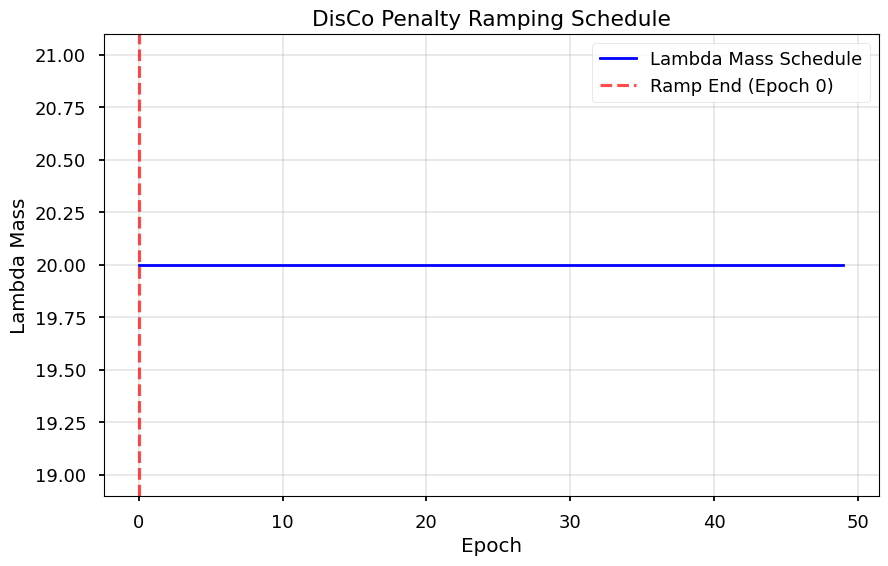

Lambda ramping schedule:
  Start: 20.0
  End: 20.0
  Ramp over: 0 epochs
  Final epochs (0-49): constant at 20.0


In [14]:
# Visualize the lambda ramping schedule
epochs = range(EPOCHS)
lambdas = [get_current_lambda(epoch) for epoch in epochs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, lambdas, 'b-', linewidth=2, label='Lambda Mass Schedule')
plt.axvline(x=LAMBDA_RAMP_EPOCHS, color='r', linestyle='--', alpha=0.7, label=f'Ramp End (Epoch {LAMBDA_RAMP_EPOCHS})')
plt.xlabel('Epoch')
plt.ylabel('Lambda Mass')
plt.title('DisCo Penalty Ramping Schedule')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"Lambda ramping schedule:")
print(f"  Start: {LAMBDA_MASS_START}")
print(f"  End: {LAMBDA_MASS_END}")
print(f"  Ramp over: {LAMBDA_RAMP_EPOCHS} epochs")
print(f"  Final epochs ({LAMBDA_RAMP_EPOCHS}-{EPOCHS-1}): constant at {LAMBDA_MASS_END}")



## 5. Training loop (`model.py` lines 88-170)

We adapt the original `train`/`val` helpers to work seamlessly on CPU/GPU and to log the DisCo decorrelation term alongside the classification loss.


In [15]:

# ---------------------------------------------------------------------------
# train_one_epoch performs a full pass over the training DataLoader.
# Objective: accumulate gradients, update model parameters, and track runtime
#            metrics (examples/sec, iterations/sec) required for the runtime log
#            requested in the evaluation plan.
# Logic: iterate over batches, compute losses, backpropagate, and average the
#        collected metrics dictionary.
# Expected behaviour: returns a dictionary containing mean losses/metrics and
#                     throughput information for the epoch.
# ---------------------------------------------------------------------------
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, lambda_mass: float = LAMBDA_MASS) -> Dict[str, float]:
    model.train()
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch, lambda_mass)
        loss.backward()
        optimizer.step()
        batch_size = batch[0].shape[0]
        total_examples += batch_size
        for key, value in metrics.items():
            agg.setdefault(key, []).append(value)
    duration = time.perf_counter() - start
    results = {key: float(np.mean(values)) for key, values in agg.items()}
    results.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return results


# ---------------------------------------------------------------------------
# evaluate mirrors train_one_epoch but without gradient updates.
# Objective: compute validation/test metrics and collect raw arrays for ROC/ABCD
#            analysis each epoch.
# Logic: disable gradients, reuse compute_losses for consistency, and keep track
#        of scores, labels, weights, and masses as numpy arrays.
# Expected behaviour: returns the concatenated arrays alongside averaged metrics.
# ---------------------------------------------------------------------------
def evaluate(model: nn.Module, loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, Dict[str, float]]:
    model.eval()
    scores, labels_all, weights_all, masses_all = [], [], [], []
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    start = time.perf_counter()
    with torch.no_grad():
        for batch in tqdm(loader, leave=False, desc="eval"):
            loss, metrics = compute_losses(model, batch)
            features, labels, weights, masses = batch
            features = features.to(DEVICE)
            _, score = model(features)
            batch_size = features.shape[0]
            total_examples += batch_size
            scores.append(score.cpu().numpy())
            labels_all.append(labels.numpy())
            weights_all.append(weights.numpy())
            masses_all.append(masses.numpy())
            agg.setdefault("loss_cls", []).append(metrics["loss_cls"])
            for key in ("accuracy", "precision", "recall", "f1"):
                agg.setdefault(key, []).append(metrics[key])
            if "dCorr_s_m" in metrics:
                agg.setdefault("dCorr_s_m", []).append(metrics["dCorr_s_m"])
    duration = time.perf_counter() - start
    metrics_mean = {key: float(np.mean(values)) for key, values in agg.items()}
    metrics_mean.update({
        "epoch_seconds": duration,
        "examples_per_second": total_examples / duration if duration > 0 else float("nan"),
        "iterations_per_second": len(loader) / duration if duration > 0 else float("nan"),
    })
    return (
        np.concatenate(scores),
        np.concatenate(labels_all),
        np.concatenate(weights_all),
        np.concatenate(masses_all),
        metrics_mean,
    )

history: List[Dict[str, Any]] = []
start_epoch = 0
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

# History tracks per-epoch metrics for later plotting and checkpoint metadata.
history: List[Dict[str, Any]] = []
start_epoch = 0
if RESUME_CHECKPOINT is not None:
    loaded_checkpoint = load_checkpoint(Path(RESUME_CHECKPOINT), model, optimizer)
    history = loaded_checkpoint.get("history", [])
    start_epoch = int(loaded_checkpoint.get("epoch", -1)) + 1
    print(f"Resuming from epoch {start_epoch}")

# for epoch in range(start_epoch, EPOCHS):
#     print(f"Epoch {epoch:03d}")
#     train_metrics = train_one_epoch(model, train_loader, optimizer)
#     s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)

#     # Compute rich validation diagnostics as mandated by the evaluation guide.
#     classification = compute_epoch_classification_metrics(s_val, y_val, w_val)
#     roc_diag = compute_roc_diagnostics(s_val, y_val, w_val)
#     abcd_stats = compute_abcd_statistics(s_val, m_val, y_val, w_val)
#     jsd_points = compute_jsd_summary(s_val, m_val, y_val, w_val)

#     record = {
#         "epoch": epoch,
#         "train_loss_cls": train_metrics.get("loss_cls", float("nan")),
#         "train_accuracy": train_metrics.get("accuracy", float("nan")),
#         "train_precision": train_metrics.get("precision", float("nan")),
#         "train_recall": train_metrics.get("recall", float("nan")),
#         "train_f1": train_metrics.get("f1", float("nan")),
#         "train_epoch_seconds": train_metrics.get("epoch_seconds", float("nan")),
#         "train_examples_per_second": train_metrics.get("examples_per_second", float("nan")),
#         "val_loss_cls": val_metrics.get("loss_cls", float("nan")),
#         "val_accuracy": classification["accuracy"],
#         "val_precision": classification["precision"],
#         "val_recall": classification["recall"],
#         "val_f1": classification["f1"],
#         "val_auc": roc_diag["auc"],
#         "val_epoch_seconds": val_metrics.get("epoch_seconds", float("nan")),
#         "val_examples_per_second": val_metrics.get("examples_per_second", float("nan")),
#     }
#     if "dCorr_s_m" in train_metrics:
#         record["train_dCorr_s_m"] = train_metrics["dCorr_s_m"]
#     if "dCorr_s_m" in val_metrics:
#         record["val_dCorr_s_m"] = val_metrics["dCorr_s_m"]
#     for target in SCORE_SIGNAL_EFFICIENCIES:
#         key = f"background_eff_at_{int(target*100)}pct_sig"
#         record[key] = roc_diag[key]
#     for item in abcd_stats["per_efficiency"]:
#         eff = int(item["target_signal_efficiency"] * 100)
#         record[f"abcd_closure_ratio_{eff}pct"] = item["closure_ratio"]
#         record[f"abcd_pull_{eff}pct"] = item["pull"]
#     aggregated = abcd_stats["aggregated"]
#     record["abcd_closure_ratio_mean"] = aggregated["closure_ratio"]["mean"]
#     record["abcd_closure_ratio_std"] = aggregated["closure_ratio"]["std"]
#     record["abcd_closure_ratio_median"] = aggregated["closure_ratio"]["median"]
#     record["abcd_pull_mean"] = aggregated["pull"]["mean"]
#     record["abcd_pull_std"] = aggregated["pull"]["std"]
#     record["abcd_pull_rms"] = aggregated["pull"]["rms"]
#     record["abcd_pull_median"] = aggregated["pull"]["median"]
#     record["transfer_factor_B_over_D_mean"] = aggregated["transfer_factor_B_over_D"]["mean"]
#     record["transfer_factor_B_over_D_std"] = aggregated["transfer_factor_B_over_D"]["std"]
#     record["transfer_factor_C_over_D_mean"] = aggregated["transfer_factor_C_over_D"]["mean"]
#     record["transfer_factor_C_over_D_std"] = aggregated["transfer_factor_C_over_D"]["std"]
#     record["sideband_ratio_B_over_C_mean"] = aggregated["sideband_ratio_B_over_C"]["mean"]
#     record["sideband_ratio_B_over_C_std"] = aggregated["sideband_ratio_B_over_C"]["std"]
#     record["sideband_stability_mean"] = aggregated["sideband_stability"]["mean"]
#     record["sideband_stability_std"] = aggregated["sideband_stability"]["std"]
#     record["asimov_significance_mean"] = aggregated["asimov_significance"]["mean"]
#     record["asimov_significance_max"] = aggregated["asimov_significance"]["max"]
#     for item in jsd_points:
#         eff = int(item["target_signal_efficiency"] * 100)
#         record[f"inverse_jsd_{eff}pct"] = item["inverse_jsd"]
#         record[f"background_rejection_{eff}pct"] = item["background_rejection"]

#     history.append(record)

#     # Persist a checkpoint capturing everything needed to resume training and
#     # redo evaluations, aligning with the per-epoch storage requirement.
#     val_record = {
#         "classification": classification,
#         "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in roc_diag.items()},
#         "abcd": abcd_stats,
#         "jsd": jsd_points,
#         "confusion_matrix": classification["confusion_matrix"].tolist(),
#     }
#     train_record = train_metrics
#     extra = {
#         "val_scores": s_val.tolist(),
#         "val_labels": y_val.tolist(),
#         "val_weights": w_val.tolist(),
#         "val_masses": m_val.tolist(),
#     }
#     save_checkpoint(epoch, model, optimizer, history, train_record, val_record, extra)

#     print(
#         f"AUC={roc_diag['auc']:.3f} | "
#         f"val_acc={classification['accuracy']:.3f} | "
#         f"closure@30%={record['abcd_closure_ratio_30pct']:.3f} | "
#         f"train_loss={train_metrics.get('loss_cls', float('nan')):.3f}"
#     )

# history_df = pd.DataFrame(history)
# history_df.tail()



In [16]:
# Anti-collapse overrides for training and QNode. Run this cell once before training.

EPS = 1e-8
ENTROPY_COEFF = 0.02          # confidence penalty weight (small)
PRIOR_MATCH_COEFF = 0.2       # batch prior-matching KL weight
VARIANCE_FLOOR = 0.02         # optional: minimum score variance target
VARIANCE_COEFF = 0.02         # weight for variance floor penalty
CLIP_NORM = 1.0               # gradient clipping
WEIGHT_DECAY = 1e-3           # AdamW weight decay
LEARNING_RATE = 5e-4          # slightly lower LR for stability

# ---- Re-define compute_losses to use BCE-with-logits + anti-collapse terms ----
def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...], lambda_mass: float = LAMBDA_MASS) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE).float()
    weights = weights.to(DEVICE).float()
    masses = masses.to(DEVICE).float()

    logits, score = model(features)  # score still used for metrics/DisCo
    # Use logit difference for BCE-with-logits (binary)
    logit = (logits[:, 1] - logits[:, 0]).contiguous()

    # Weighted pos_weight for class imbalance (computed per-batch)
    pos_mask = labels > 0.5
    w_pos = weights[pos_mask].sum()
    w_neg = weights[~pos_mask].sum()
    pos_weight = (w_neg / (w_pos + EPS)).clamp(min=0.5, max=5.0)

    # Weighted BCE-with-logits
    per_example = F.binary_cross_entropy_with_logits(logit, labels, reduction="none", pos_weight=pos_weight)
    loss_cls = (weights * per_example).sum() / (weights.sum() + EPS)

    # Anti-collapse: (1) batch prior matching (weighted)
    probs = torch.softmax(logits, dim=1)
    wsum = weights.sum() + EPS
    p_bar = (probs * weights.unsqueeze(1)).sum(dim=0) / wsum
    prior_pos = (w_pos / (w_pos + w_neg + EPS)).clamp(1e-3, 1 - 1e-3)
    prior = torch.stack([1.0 - prior_pos, prior_pos])
    kl_prior = (p_bar * (p_bar.add(EPS).log() - prior.add(EPS).log())).sum()

    # Anti-collapse: (2) confidence penalty (maximize entropy => add -H)
    entropy = -(probs * (probs + EPS).log()).sum(dim=1).mean()
    conf_penalty = -ENTROPY_COEFF * entropy

    # Optional: encourage non-zero variance of the score
    mu = (weights * score).sum() / wsum
    var = (weights * (score - mu).pow(2)).sum() / wsum
    var_penalty = VARIANCE_COEFF * F.relu(VARIANCE_FLOOR - var)

    loss = loss_cls + PRIOR_MATCH_COEFF * kl_prior + conf_penalty + var_penalty

    # DisCo decorrelation on background (unchanged)
    background = labels < 0.5
    metrics = {
        "loss_cls": float(loss_cls.detach().cpu()),
        "accuracy": float(compute_weighted_classification_stats(labels, score, weights)["accuracy"]),
    }
    if background.any() and lambda_mass > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + lambda_mass * d_mass
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics

# ---- Gradient clipping in the training step ----
def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, lambda_mass: float = LAMBDA_MASS) -> Dict[str, float]:
    model.train()
    agg: Dict[str, List[float]] = {}
    total_examples = 0
    for batch in tqdm(loader, leave=False, desc="train"):
        optimizer.zero_grad(set_to_none=True)
        loss, metrics = compute_losses(model, batch, lambda_mass)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)
        optimizer.step()
        batch_size = batch[0].shape[0]
        total_examples += batch_size
        for k, v in metrics.items():
            agg.setdefault(k, []).append(v)
        agg.setdefault("loss", []).append(float(loss.detach().cpu()))
    return {k: float(np.mean(v)) for k, v in agg.items()}

# ---- Widen quantum readout and bound embedding ----
if BACKEND == "qml" and hasattr(model, "qlayer"):
    # Rebuild the PennyLane module with safer embedding and richer readout
    class PennyLaneSingleDisco(nn.Module):
        def __init__(self, n_features: int, n_qubits: int = globals().get("N_QUBITS", 6), layers: int = globals().get("QML_LAYERS", 3), device_name: str = globals().get("QML_DEVICE", "default.qubit")):
            if not PENNYLANE_AVAILABLE:
                raise RuntimeError("PennyLane is not installed.")
            super().__init__()
            self.n_qubits = n_qubits
            self.n_features = n_features
            self.compressor = nn.Sequential(
                nn.Linear(n_features, n_qubits),
                nn.LeakyReLU(),
                nn.Dropout(p=0.1),
            )
            qdevice = qml.device(device_name, wires=n_qubits)
            weight_shapes = { "weights_strong": (layers, n_qubits, 3) }

            @qml.qnode(qdevice, interface="torch")
            def circuit(inputs, weights_strong):
                take = min(inputs.shape[-1], n_qubits)
                if inputs.ndim == 1:
                    x_pad = torch.zeros((n_qubits,), dtype=inputs.dtype, device=inputs.device)
                    x_pad[:take] = inputs[:take]
                else:
                    pad_shape = tuple(list(inputs.shape[:-1]) + [n_qubits])
                    x_pad = torch.zeros(pad_shape, dtype=inputs.dtype, device=inputs.device)
                    x_pad[..., :take] = inputs[..., :take]
                angles = torch.pi * torch.tanh(x_pad)  # bound angles for stable grads
                qml.templates.AngleEmbedding(angles, wires=range(n_qubits), rotation='Y')
                qml.templates.StronglyEntanglingLayers(weights=weights_strong, wires=range(n_qubits))
                return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

            self.qlayer = qml.qnn.TorchLayer(circuit, weight_shapes)
            self.head = nn.Linear(n_qubits, 2)

        def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
            angles = self.compressor(x)
            q_features = self.qlayer(angles)
            logits = self.head(q_features)
            score = F.softmax(logits, dim=1)[:, 1]
            return logits, score

    # Rebuild model and optimizer with AdamW
    model = build_model(len(FEATURE_NAMES))
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
else:
    # Even for classical-only, AdamW + clipping + anti-collapse helps
    try:
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    except Exception:
        pass

print("Anti-collapse overrides active: logits-BCE, KL prior matching, confidence penalty, gradient clipping, AdamW.")

Anti-collapse overrides active: logits-BCE, KL prior matching, confidence penalty, gradient clipping, AdamW.


In [17]:
# Fix: compute_losses returns precision/recall/F1 (keeps anti-collapse + DisCo)
# Run this cell once before training/evaluation

def compute_losses(model: nn.Module, batch: Tuple[torch.Tensor, ...], lambda_mass: float = LAMBDA_MASS) -> Tuple[torch.Tensor, Dict[str, float]]:
    features, labels, weights, masses = batch
    features = features.to(DEVICE)
    labels = labels.to(DEVICE).float()
    weights = weights.to(DEVICE).float()
    masses = masses.to(DEVICE).float()

    logits, score = model(features)
    logit = (logits[:, 1] - logits[:, 0]).contiguous()

    # Batch imbalance handling
    EPS = globals().get("EPS", 1e-8)
    pos_mask = labels > 0.5
    w_pos = weights[pos_mask].sum()
    w_neg = weights[~pos_mask].sum()
    pos_weight = (w_neg / (w_pos + EPS)).clamp(min=0.5, max=5.0)

    # Weighted BCE-with-logits (classification loss)
    per_example = F.binary_cross_entropy_with_logits(logit, labels, reduction="none", pos_weight=pos_weight)
    loss_cls = (weights * per_example).sum() / (weights.sum() + EPS)

    # Anti-collapse regularizers (safe defaults if not previously defined)
    ENTROPY_COEFF = float(globals().get("ENTROPY_COEFF", 0.01))
    PRIOR_MATCH_COEFF = float(globals().get("PRIOR_MATCH_COEFF", 0.1))
    VARIANCE_FLOOR = float(globals().get("VARIANCE_FLOOR", 0.02))
    VARIANCE_COEFF = float(globals().get("VARIANCE_COEFF", 0.02))

    probs = torch.softmax(logits, dim=1)
    wsum = weights.sum() + EPS
    p_bar = (probs * weights.unsqueeze(1)).sum(dim=0) / wsum
    prior_pos = (w_pos / (w_pos + w_neg + EPS)).clamp(1e-3, 1 - 1e-3)
    prior = torch.stack([1.0 - prior_pos, prior_pos])
    kl_prior = (p_bar * (p_bar.add(EPS).log() - prior.add(EPS).log())).sum()

    entropy = -(probs * (probs + EPS).log()).sum(dim=1).mean()
    conf_penalty = -ENTROPY_COEFF * entropy

    mu = (weights * score).sum() / wsum
    var = (weights * (score - mu).pow(2)).sum() / wsum
    var_penalty = VARIANCE_COEFF * F.relu(VARIANCE_FLOOR - var)

    loss = loss_cls + PRIOR_MATCH_COEFF * kl_prior + conf_penalty + var_penalty

    # DisCo decorrelation on background
    background = labels < 0.5
    if background.any() and lambda_mass > 0.0:
        w_bkg = torch.ones_like(weights[background])
        d_mass = distance_corr_safe(score[background], masses[background], w_bkg)
        loss = loss + lambda_mass * d_mass
    else:
        d_mass = None

    # Full classification stats expected by evaluate()
    stats = compute_weighted_classification_stats(labels, score, weights)
    metrics: Dict[str, float] = {
        "loss_cls": float(loss_cls.detach().cpu()),
        "accuracy": float(stats.get("accuracy", float("nan"))),
        "precision": float(stats.get("precision", float("nan"))),
        "recall": float(stats.get("recall", float("nan"))),
        "f1": float(stats.get("f1", float("nan"))),
    }
    if d_mass is not None:
        metrics["dCorr_s_m"] = float(d_mass.detach().cpu())

    return loss, metrics

print("compute_losses override loaded: metrics now include precision/recall/F1.")


compute_losses override loaded: metrics now include precision/recall/F1.


In [18]:



# Updated training loop with lambda ramping
for epoch in range(start_epoch, EPOCHS):
    print(f"Epoch {epoch:03d}")
    # Get current lambda value for ramping
    current_lambda = get_current_lambda(epoch)
    print(f"Current lambda_mass: {current_lambda:.2f}")
    
    train_metrics = train_one_epoch(model, train_loader, optimizer, current_lambda)
    s_val, y_val, w_val, m_val, val_metrics = evaluate(model, val_loader)

    # Compute rich validation diagnostics as mandated by the evaluation guide.
    classification = compute_epoch_classification_metrics(s_val, y_val, w_val)
    roc_diag = compute_roc_diagnostics(s_val, y_val, w_val)
    abcd_stats = compute_abcd_statistics(s_val, m_val, y_val, w_val)
    jsd_points = compute_jsd_summary(s_val, m_val, y_val, w_val)

    record = {
        "epoch": epoch,
        "lambda_mass": current_lambda,  # Track current lambda value
        "train_loss_cls": train_metrics.get("loss_cls", float("nan")),
        "train_accuracy": train_metrics.get("accuracy", float("nan")),
        "train_precision": train_metrics.get("precision", float("nan")),
        "train_recall": train_metrics.get("recall", float("nan")),
        "train_f1": train_metrics.get("f1", float("nan")),
        "train_epoch_seconds": train_metrics.get("epoch_seconds", float("nan")),
        "train_examples_per_second": train_metrics.get("examples_per_second", float("nan")),
        "val_loss_cls": val_metrics.get("loss_cls", float("nan")),
        "val_accuracy": classification["accuracy"],
        "val_precision": classification["precision"],
        "val_recall": classification["recall"],
        "val_f1": classification["f1"],
        "val_auc": roc_diag["auc"],
        "val_epoch_seconds": val_metrics.get("epoch_seconds", float("nan")),
        "val_examples_per_second": val_metrics.get("examples_per_second", float("nan")),
    }
    if "dCorr_s_m" in train_metrics:
        record["train_dCorr_s_m"] = train_metrics["dCorr_s_m"]
    if "dCorr_s_m" in val_metrics:
        record["val_dCorr_s_m"] = val_metrics["dCorr_s_m"]
    for target in SCORE_SIGNAL_EFFICIENCIES:
        key = f"background_eff_at_{int(target*100)}pct_sig"
        record[key] = roc_diag[key]
    for item in abcd_stats["per_efficiency"]:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"abcd_closure_ratio_{eff}pct"] = item["closure_ratio"]
        record[f"abcd_pull_{eff}pct"] = item["pull"]
    aggregated = abcd_stats["aggregated"]
    record["abcd_closure_ratio_mean"] = aggregated["closure_ratio"]["mean"]
    record["abcd_closure_ratio_std"] = aggregated["closure_ratio"]["std"]
    record["abcd_closure_ratio_median"] = aggregated["closure_ratio"]["median"]
    record["abcd_pull_mean"] = aggregated["pull"]["mean"]
    record["abcd_pull_std"] = aggregated["pull"]["std"]
    record["abcd_pull_rms"] = aggregated["pull"]["rms"]
    record["abcd_pull_median"] = aggregated["pull"]["median"]
    record["transfer_factor_B_over_D_mean"] = aggregated["transfer_factor_B_over_D"]["mean"]
    record["transfer_factor_B_over_D_std"] = aggregated["transfer_factor_B_over_D"]["std"]
    record["transfer_factor_C_over_D_mean"] = aggregated["transfer_factor_C_over_D"]["mean"]
    record["transfer_factor_C_over_D_std"] = aggregated["transfer_factor_C_over_D"]["std"]
    record["sideband_ratio_B_over_C_mean"] = aggregated["sideband_ratio_B_over_C"]["mean"]
    record["sideband_ratio_B_over_C_std"] = aggregated["sideband_ratio_B_over_C"]["std"]
    record["sideband_stability_mean"] = aggregated["sideband_stability"]["mean"]
    record["sideband_stability_std"] = aggregated["sideband_stability"]["std"]
    record["asimov_significance_mean"] = aggregated["asimov_significance"]["mean"]
    record["asimov_significance_max"] = aggregated["asimov_significance"]["max"]
    for item in jsd_points:
        eff = int(item["target_signal_efficiency"] * 100)
        record[f"inverse_jsd_{eff}pct"] = item["inverse_jsd"]
        record[f"background_rejection_{eff}pct"] = item["background_rejection"]

    history.append(record)

    # Persist a checkpoint capturing everything needed to resume training and
    # redo evaluations, aligning with the per-epoch storage requirement.
    val_record = {
        "classification": classification,
        "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in roc_diag.items()},
        "abcd": abcd_stats,
        "jsd": jsd_points,
        "confusion_matrix": classification["confusion_matrix"].tolist(),
    }
    train_record = train_metrics
    extra = {
        "val_scores": s_val.tolist(),
        "val_labels": y_val.tolist(),
        "val_weights": w_val.tolist(),
        "val_masses": m_val.tolist(),
    }
    save_checkpoint(epoch, model, optimizer, history, train_record, val_record, extra)

    print(
        f"AUC={roc_diag['auc']:.3f} | "
        f"val_acc={classification['accuracy']:.3f} | "
        f"closure@30%={record['abcd_closure_ratio_30pct']:.3f} | "
        f"train_loss={train_metrics.get('loss_cls', float('nan')):.3f} | "
        f"λ={current_lambda:.1f}"
    )

history_df = pd.DataFrame(history)
history_df.tail()


Epoch 000
Current lambda_mass: 20.00


OutOfMemoryError: CUDA out of memory. Tried to allocate 320.00 MiB. GPU 0 has a total capacity of 39.38 GiB of which 179.06 MiB is free. Process 788523 has 11.70 GiB memory in use. Process 467927 has 1.56 GiB memory in use. Process 1647418 has 9.32 GiB memory in use. Process 1069582 has 15.67 GiB memory in use. Including non-PyTorch memory, this process has 844.00 MiB memory in use. Of the allocated memory 331.63 MiB is allocated by PyTorch, and 12.37 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)


### Training diagnostics

We track the classification loss and the distance-correlation penalty to verify convergence and decorrelation strength.


In [ ]:

# Visual summary of training history (losses, AUC, decorrelation, throughput).
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# Panel 0: weighted binary cross-entropy on train vs validation sets.
axes[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train", marker="o")
axes[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val", marker="s")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Binary cross-entropy")
axes[0].set_title("Loss history")
axes[0].legend()

# Panel 1: AUC progression across epochs (higher is better signal/background separation).
axes[1].plot(history_df["epoch"], history_df["val_auc"], marker="o")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUC")
axes[1].set_title("Validation ROC AUC")
axes[1].grid(True)

# Panel 2: distance correlation term monitoring the DisCo penalty strength.
if "train_dCorr_s_m" in history_df.columns:
    axes[2].plot(history_df["epoch"], history_df["train_dCorr_s_m"], label="train")
if "val_dCorr_s_m" in history_df.columns:
    axes[2].plot(history_df["epoch"], history_df["val_dCorr_s_m"], label="val")
axes[2].set_xlabel("Epoch")
axes[2].set_ylabel("Distance correlation")
axes[2].set_title("Decorrelating score vs jet mass")
axes[2].legend()

# Panel 3: runtime throughput useful for planning segmented jobs under time limits.
axes[3].plot(history_df["epoch"], history_df["train_examples_per_second"], label="train", marker="o")
axes[3].plot(history_df["epoch"], history_df["val_examples_per_second"], label="val", marker="s")
axes[3].set_xlabel("Epoch")
axes[3].set_ylabel("Examples per second")
axes[3].set_title("Throughput diagnostics")
axes[3].legend()

plt.tight_layout()
plt.show()



In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

# # Loss evolution
# axes[0].plot(history_df["epoch"], history_df["train_loss_cls"], label="train", marker="o")
# axes[0].plot(history_df["epoch"], history_df["val_loss_cls"], label="val", marker="s")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Binary cross-entropy")
# axes[0].set_title("Loss history")
# axes[0].legend()

# # Classification metrics
# axes[1].plot(history_df["epoch"], history_df["train_accuracy"], label="train acc", marker="o")
# axes[1].plot(history_df["epoch"], history_df["val_accuracy"], label="val acc", marker="s")
# axes[1].plot(history_df["epoch"], history_df["val_precision"], label="val precision", linestyle="--")
# axes[1].plot(history_df["epoch"], history_df["val_recall"], label="val recall", linestyle=":")
# axes[1].plot(history_df["epoch"], history_df["val_f1"], label="val F1", linestyle="-." )
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Score")
# axes[1].set_ylim(0.0, 1.05)
# axes[1].set_title("Classification summary")
# axes[1].legend(loc="lower right")

# # ABCD closure and ROC
# axes[2].plot(history_df["epoch"], history_df["val_auc"], label="AUC", marker="o")
# axes[2].plot(history_df["epoch"], 1.0 / np.maximum(history_df["background_eff_at_30pct_sig"], 1e-6), label="1/ε_B @ 30%", marker="s")
# axes[2].plot(history_df["epoch"], history_df["abcd_closure_ratio_30pct"], label="closure ratio @ 30%", linestyle="--")
# axes[2].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
# axes[2].set_xlabel("Epoch")
# axes[2].set_ylabel("Metric value")
# axes[2].set_title("ROC vs. ABCD stability")
# axes[2].legend()
# axes[2].set_yscale("log")

# # Runtime diagnostics
# axes[3].plot(history_df["epoch"], history_df["train_epoch_seconds"], label="train", marker="o")
# axes[3].plot(history_df["epoch"], history_df["val_epoch_seconds"], label="val", marker="s")
# axes[3].set_xlabel("Epoch")
# axes[3].set_ylabel("Seconds")
# axes[3].set_title("Per-epoch wall-clock time")
# axes[3].legend()

# plt.tight_layout()
# plt.show()

# Safer plotting for HPC: chunk long paths, decimate, sanitize, and limit rows
plt.rcParams['agg.path.chunksize'] = 10000
plot_df = history_df.tail(min(len(history_df), 2000)).copy()

def decimate(n):  # reduce marker density
    return max(1, n // 200)

# Panel 0: loss
axes[0].plot(plot_df["epoch"], plot_df["train_loss_cls"], label="train", marker=None)
axes[0].plot(plot_df["epoch"], plot_df["val_loss_cls"], label="val", marker=None)
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Binary cross-entropy"); axes[0].set_title("Loss history"); axes[0].legend()

# Panel 1: classification summary (no markers for long series)
axes[1].plot(plot_df["epoch"], plot_df["train_accuracy"], label="train acc")
axes[1].plot(plot_df["epoch"], plot_df["val_accuracy"], label="val acc")
axes[1].plot(plot_df["epoch"], plot_df["val_precision"], label="val precision", linestyle="--")
axes[1].plot(plot_df["epoch"], plot_df["val_recall"], label="val recall", linestyle=":")
axes[1].plot(plot_df["epoch"], plot_df["val_f1"], label="val F1", linestyle="-.")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("Score"); axes[1].set_ylim(0.0, 1.05); axes[1].set_title("Classification summary")
axes[1].legend(loc="lower right")

# Panel 2: ROC vs ABCD stability (log-safe)
bkg_eff = plot_df.get("background_eff_at_30pct_sig")
if bkg_eff is not None:
    inv_bkg = 1.0 / np.clip(bkg_eff.astype(float), 1e-6, 1e6)
    axes[2].plot(plot_df["epoch"], plot_df["val_auc"], label="AUC")
    axes[2].plot(plot_df["epoch"], inv_bkg, label="1/ε_B @ 30%")
    if np.all(inv_bkg > 0):
        axes[2].set_yscale("log")
    axes[2].plot(plot_df["epoch"], plot_df.get("abcd_closure_ratio_30pct", np.nan), label="closure ratio @ 30%", linestyle="--")
    axes[2].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
    axes[2].set_xlabel("Epoch"); axes[2].set_ylabel("Metric value"); axes[2].set_title("ROC vs. ABCD stability"); axes[2].legend()
else:
    axes[2].set_visible(False)

# Panel 3: runtime diagnostics
axes[3].plot(plot_df["epoch"], plot_df["train_epoch_seconds"], label="train")
axes[3].plot(plot_df["epoch"], plot_df["val_epoch_seconds"], label="val")
axes[3].set_xlabel("Epoch"); axes[3].set_ylabel("Seconds"); axes[3].set_title("Per-epoch wall-clock time"); axes[3].legend()

plt.tight_layout()
plt.savefig("metrics_compact.png", dpi=120)  # avoid massive inline payload
plt.close(fig)
from IPython.display import Image, display
display(Image("metrics_compact.png"))


## 6. Evaluation (`evaluation.py` lines 1-70)

We reproduce the single-score diagnostics: ROC curves, background mass sculpting, and the Jensen-Shannon divergence versus background rejection figure of merit used in the paper.


In [ ]:

# Final evaluation on the held-out test set following the evaluation guide.
from importlib import reload
import evaluation
reload(evaluation)
from evaluation import JSDvsR

# Run the evaluate() helper to obtain raw scores, labels, weights, masses.
s_test, y_test, w_test, m_test, test_metrics = evaluate(model, test_loader)

# Compute the suite of diagnostics requested: classification metrics, ROC, ABCD closure,
# Jensen–Shannon vs rejection, and distance correlation on pure background.
classification_test = compute_epoch_classification_metrics(s_test, y_test, w_test)
roc_test = compute_roc_diagnostics(s_test, y_test, w_test)
abcd_test = compute_abcd_statistics(s_test, m_test, y_test, w_test)
jsd_test = compute_jsd_summary(s_test, m_test, y_test, w_test)

background = y_test < 0.5
if background.any():
    d_test = distance_corr_safe(
        torch.as_tensor(s_test[background]),
        torch.as_tensor(m_test[background]),
        torch.ones_like(torch.as_tensor(m_test[background])),
    ).item()
else:
    d_test = float("nan")

print("Test-set diagnostics:")
print(f"  AUC = {roc_test['auc']:.3f}")
print(f"  Accuracy = {classification_test['accuracy']:.3f}")
print(f"  Precision = {classification_test['precision']:.3f}")
print(f"  Recall = {classification_test['recall']:.3f}")
print(f"  F1-score = {classification_test['f1']:.3f}")
print(f"  Background distance-correlation(score, mass) = {d_test:.4f}")

# Visualise ROC, confusion matrix, mass sculpting, and ABCD closure vs rejection.
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()
axes[0].plot(roc_test["fpr"], roc_test["tpr"], label=f"ROC (AUC={roc_test['auc']:.3f})")
axes[0].set_xlabel("Background efficiency ε_B")
axes[0].set_ylabel("Signal efficiency ε_S")
axes[0].set_title("Receiver Operating Characteristic")
axes[0].legend(loc="lower right")
axes[0].grid(True)
cm = classification_test["confusion_matrix"]
im = axes[1].imshow(cm, cmap="viridis")
axes[1].set_xticks([0, 1])
axes[1].set_yticks([0, 1])
axes[1].set_xticklabels(["Predicted background", "Predicted signal"])
axes[1].set_yticklabels(["True background", "True signal"])
axes[1].set_title("Weighted confusion matrix")
for (i, j), value in np.ndenumerate(cm):
    axes[1].text(j, i, f"{value:.0f}", ha="center", va="center", color="white" if value > cm.max() / 2 else "black")
fig.colorbar(im, ax=axes[1])
nbins = ABCD_HISTOGRAM_BINS
mass_range = (m_test.min(), m_test.max())
axes[2].hist(
    m_test[background], bins=nbins, range=mass_range, weights=w_test[background],
    histtype="step", label="All background", linewidth=2
)
cut = weighted_quantile(s_test[y_test > 0.5], 1 - 0.3, w_test[y_test > 0.5])
sel = background & (s_test > cut)
axes[2].hist(
    m_test[sel], bins=nbins, range=mass_range, weights=w_test[sel],
    histtype="stepfilled", alpha=0.4, label="Background above 30% signal-eff cut"
)
axes[2].set_xlabel("Jet mass [GeV]")
axes[2].set_ylabel("Weighted events")
axes[2].set_title("Mass sculpting diagnostic")
axes[2].legend()
rejections = [item["background_rejection"] for item in jsd_test]
closures = [item["closure_ratio"] for item in abcd_test["per_efficiency"]]
labels_eff = [int(item["target_signal_efficiency"] * 100) for item in abcd_test["per_efficiency"]]
axes[3].scatter(rejections, closures, c=labels_eff, cmap="plasma", s=120)
for rej, clo, eff in zip(rejections, closures, labels_eff):
    axes[3].annotate(f"{eff}%", (rej, clo))
axes[3].axhspan(0.9, 1.1, color="grey", alpha=0.15, label="±10% closure band")
axes[3].set_xlabel("Background rejection 1/ε_B")
axes[3].set_ylabel("Closure ratio N_pred/N_true")
axes[3].set_title("ABCD closure vs. rejection")
axes[3].set_xscale("log")
axes[3].legend()
plt.tight_layout()
plt.show()

# Tabulate ABCD and JSD results for the notebook summary.
abcd_rows = []
for abcd_entry, jsd_entry in zip(abcd_test["per_efficiency"], jsd_test):
    eff = int(abcd_entry["target_signal_efficiency"] * 100)
    abcd_rows.append({
        "signal_efficiency_percent": eff,
        "score_cut": abcd_entry["score_cut"],
        "background_prediction": abcd_entry["predicted_bg"],
        "closure_ratio": abcd_entry["closure_ratio"],
        "closure_error_percent": abcd_entry["closure_error_pct"],
        "pull": abcd_entry["pull"],
        "transfer_factor_B_over_D": abcd_entry["transfer_factor_B_over_D"],
        "transfer_factor_C_over_D": abcd_entry["transfer_factor_C_over_D"],
        "sideband_ratio_B_over_C": abcd_entry["sideband_ratio_B_over_C"],
        "sideband_stability": abcd_entry["sideband_stability"],
        "signal_in_A": abcd_entry["signal_in_A"],
        "observed_total_in_A": abcd_entry["observed_total_in_A"],
        "asimov_significance": abcd_entry["asimov_significance"],
        "background_rejection": jsd_entry["background_rejection"],
        "inverse_jsd": jsd_entry["inverse_jsd"],
    })
abcd_df = pd.DataFrame(abcd_rows)
abcd_df

aggregated_df = pd.json_normalize(abcd_test["aggregated"], sep="_")
aggregated_df.T



## 7. Persist artefacts

Save inference scores and the trained model weights for downstream ABCDisCo or `pyhf` studies.


In [ ]:
def to_serializable(obj: Any):
    # Convert numpy scalars/arrays and torch tensors to built-in Python types recursively.
    if isinstance(obj, (np.floating, np.integer, np.bool_)):
        return obj.item()
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if torch.is_tensor(obj):
        if obj.ndim == 0:
            return obj.item()
        return obj.detach().cpu().tolist()
    if isinstance(obj, dict):
        return {str(k): to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [to_serializable(v) for v in obj]
    return obj

results_df = pd.DataFrame({
    "score": s_test,
    "label": y_test,
    "weight": w_test,
    "mass": m_test,
})
results_df.head()

summary_payload = {
    "classification": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v) if np.isscalar(v) else v) for k, v in classification_test.items() if k != "confusion_matrix"},
    "confusion_matrix": classification_test["confusion_matrix"].tolist(),
    "roc": {k: (v.tolist() if isinstance(v, np.ndarray) else float(v)) for k, v in roc_test.items()},
    "abcd": abcd_test,
    "jsd": jsd_test,
    "distance_correlation": d_test,
}
summary_path = CHECKPOINT_DIR / "test_evaluation.json"
with open(summary_path, "w") as handle:
    json.dump(to_serializable(summary_payload), handle, indent=2)
print(f"Saved detailed test summary to {summary_path}")




## 8. Extending to Double-DisCo & QML studies

- **Recovering the paper-level numbers**: set `FULL_DATASET = True`, increase `EPOCHS` to 200, and sweep `LAMBDA_MASS` in the range 50-400 as in the reference scans.
- **Quantum experiments**: switch `BACKEND = "qml"`, tune `N_QUBITS`/`QML_LAYERS`, and initialise the PennyLane device with `qml.seed(SEED)` for reproducibility.
- **Transition to Double-DisCo**: after validating this notebook, open `ABCDisCo_tutorial.ipynb` for the two-network variant and reuse the saved preprocessing steps to initialise the dual heads.
